**Team:** `Amin Mekacher` & `Tim Tuuva`

# Chapter 3 : Object Tracking

In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import math
import tarfile
import time as _time
from utils import *
%matplotlib inline

#Import all the extra you may need.

## 1 Video Processing and Detection. 

In this first part of chapter 3, you will be asked to construct a series of functions tools to handle video processing and basic detection. You will use the same HOG+SVM classifier from Chapter 2 and adapt it to handle video input.

In contrast to the previous assignments, in this assignment, we will not provide a guided skeleton of the function. You will use any high level (already implemented) function from OpenCV to complete the exercise specifications and outputs. In addition, you will be asked to search in the documentation (or your favourite reference) the specific usage of the functions. 

__Section Objectives:__

* Construct a Video processing pipeline.
* Use OpenCV functions on the video frames for human detection.
* Analyse and compare tracking methodes proposed by OpenCV

__Data__:

The chapter data included inside ``../data/videos`` folder contains three sample videos to test your functions.


### 1.1 Reading/Writing video

A video file can be abstracted as a bunch of images of the same dimensions in order (*i.e. collection*). Our first task is to complete the function `transform_video_file(...)` which will operate on every frames of a given video file. The following steps are required:

- Open video file
- Iterate overall frames or a subset of them (based on `n_frame` parameter)
- Apply the processing function. The function's signature needs to be `function(np.array, Any) -> Any`

To read videos you can use the OpenCV build-in functions, namely `cv::VideoCapture` class. More informations is available in the [docs](https://docs.opencv.org/3.4.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).


In [2]:
def transform_video_file(file_path, function, params=None, n_frame=-1):
    """
    Given the path of a video file (file_path) the function reads every frame of the input video and applies a given
    transformation (function) using the parameters (params)

    :input_image:       Input video file path 
    :function:          Function be applied to each frame of the image. Signature `function(np.array, Any) -> Any`
    :params:            Any parameter needed for the function above.
    :n_frame:           Maxiumum number of frame to read. Default `-1`, read all the content
    :return:            output_handler this can be anything you may need to save your results.
    """
    output_handler = []
    # Open video
    cap = cv.VideoCapture(file_path)
    if cap.isOpened():
    # Credit to https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html    
        # Init
        output_handler = list()
        n = n_frame
        while(n != 0):
            # --n != 0 doesn't exist in python sadly
            n -= 1
            
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            # Ending condition
            if(ret):
                # Our operations on the frame come here
                output_handler.append(function(frame, params))
            else:
                break

        # When everything done, release the capture
        cap.release()
        cv2.destroyAllWindows()
                        
    else:
        raise ValueError('Can not open file: {}'.format(file_path))
    # Close reader
    cap.release()
    # Return custom structure
    return output_handler

### 1.2 Example:

The example below shows how the `transform_video_file` can be used. It will open the video named `speaker.avi` and process only the first **2** frames.

In [3]:
# Example of usage:
def dummy_function(image, params):
    if('dummy_function' in params[0]):
        print('Func: "{}", Message "{}", File: "{}"'.format(params[0], params[1], params[2]))
        print('Image dims: {}'.format(image.shape))
    return 'I did it'
# Define parameters
file_name = '../data/videos/speaker.avi'
extra_params = ['dummy_function', 'Hello from the video file', file_name];

# Process single frame
transform_video_file(file_path=file_name, function=dummy_function, params=extra_params, n_frame=2)

Func: "dummy_function", Message "Hello from the video file", File: "../data/videos/speaker.avi"
Image dims: (720, 1280, 3)
Func: "dummy_function", Message "Hello from the video file", File: "../data/videos/speaker.avi"
Image dims: (720, 1280, 3)


['I did it', 'I did it']

### 1.3 Testing your function:

To test your function you need to process the video: ``../data/videos/video_gym.avi``. At each frame, you will count the number of __blue__ pixel. At the end you should return two outputs:

* The __frame number__ with the maximum number of blue pixels
* The __image__ frame with more blue pixels in greyscale, except for the blue pixels.

Display the image and the frame number. 

__Hint:__ Consider a blue pixel as any pixel in the range of the blue color in HSV: 
``([90,120,120]) , [130,255,255])``. 

__Hint 2__: Check the first assignment if you have no idea what am I talking about.  

In [4]:
def processing_fn(image, params):
    """
    Count the number of blue pixels in a given image. This function also extracts the region where the pixels are blue
    in form of a mask.
    
    :param image:  Frame to analyse
    :param params: Extra parameters that my be required by the functions
    """

    ## Credit to TAs, assignment 1
    # 2. Convert BGR to HSV for an input image
    hsv = cv.cvtColor(image.copy(), cv.COLOR_BGR2HSV)

    # 3. Define range of blue color in HSV
    lower_blue = np.array([80,90,90])
    upper_blue = np.array([150,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv, lower_blue, upper_blue)

    # Count number of white pixel in the mask
    count = np.sum(mask == np.max(mask))
    
    # Done
    return (count, mask, image) # Magic structure with the number of blue pixels + mask + image


# Video file
file_path =  os.path.join('..','data', 'videos', 'video_gym.avi')
outputs = transform_video_file(file_path, processing_fn);

Frame 64 has the most blue pixel


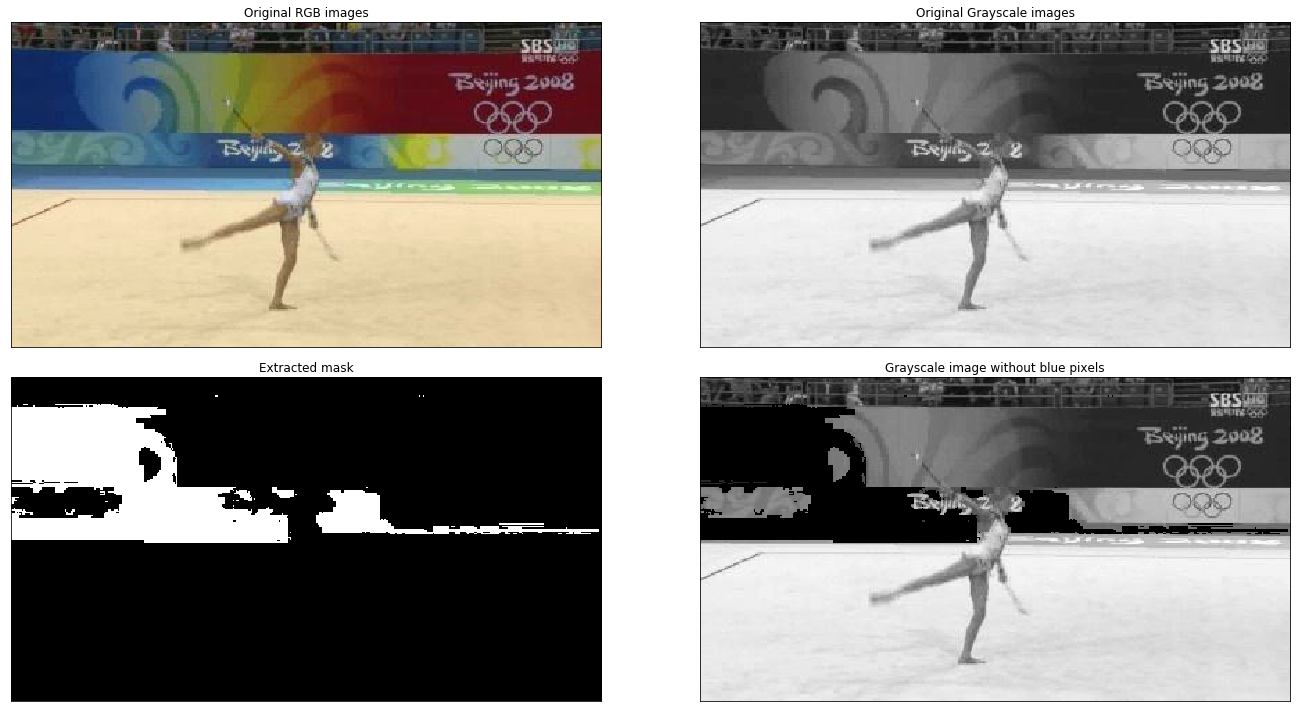

In [5]:
# Retrieve the frame number with the most blue pixels
max_array = max(outputs)
print("Frame",outputs.index(max_array), "has the most blue pixel")

# Greyscale image with the mask applied
grey = cv.cvtColor(max(outputs)[2], cv.COLOR_BGR2GRAY)
# and its mask:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0,0].imshow(cv.cvtColor(max_array[2], cv.COLOR_BGR2RGB))
ax[0,0].set_title('Original RGB images')
ax[0,1].imshow(grey, cmap='gray')
ax[0,1].set_title('Original Grayscale images')
ax[1,0].imshow(max_array[1], cmap='gray')
ax[1,0].set_title('Extracted mask')
ax[1,1].imshow(cv2.bitwise_and(grey,grey,mask = cv2.bitwise_not(max_array[1])), cmap='gray')
ax[1,1].set_title('Grayscale image without blue pixels')

# Remove ticks
ax = ax.ravel()
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
#
plt.tight_layout()
plt.show()

At each 30 seconds of the video, on its repectively frame (i.e. `frame_idx % 30 == 0`), show the following results

- Extracted mask
- Number of blue pixels counted


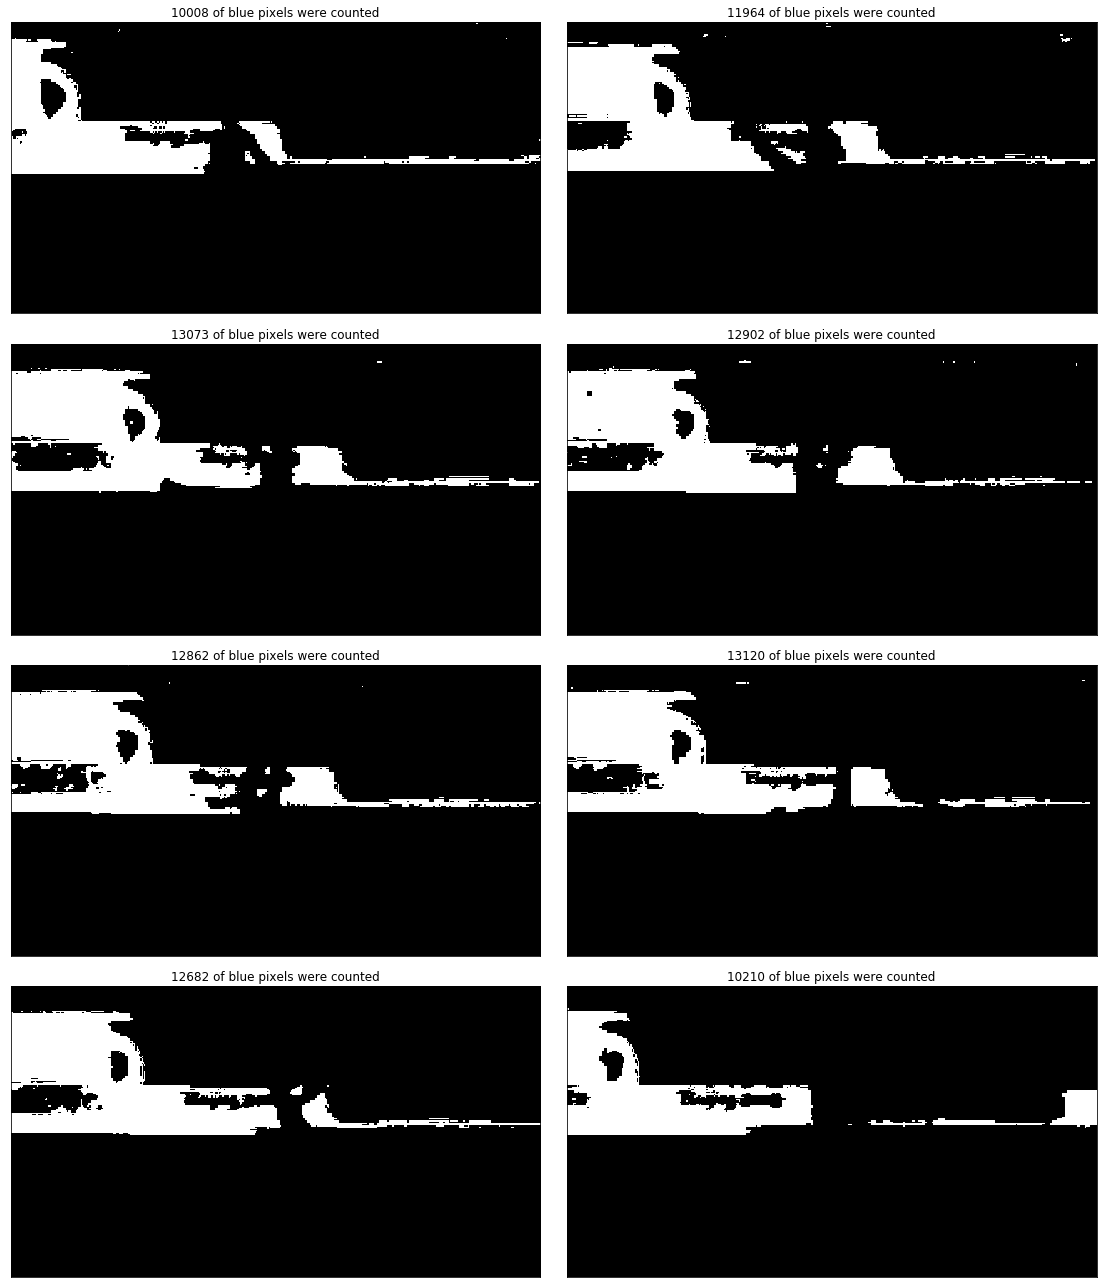

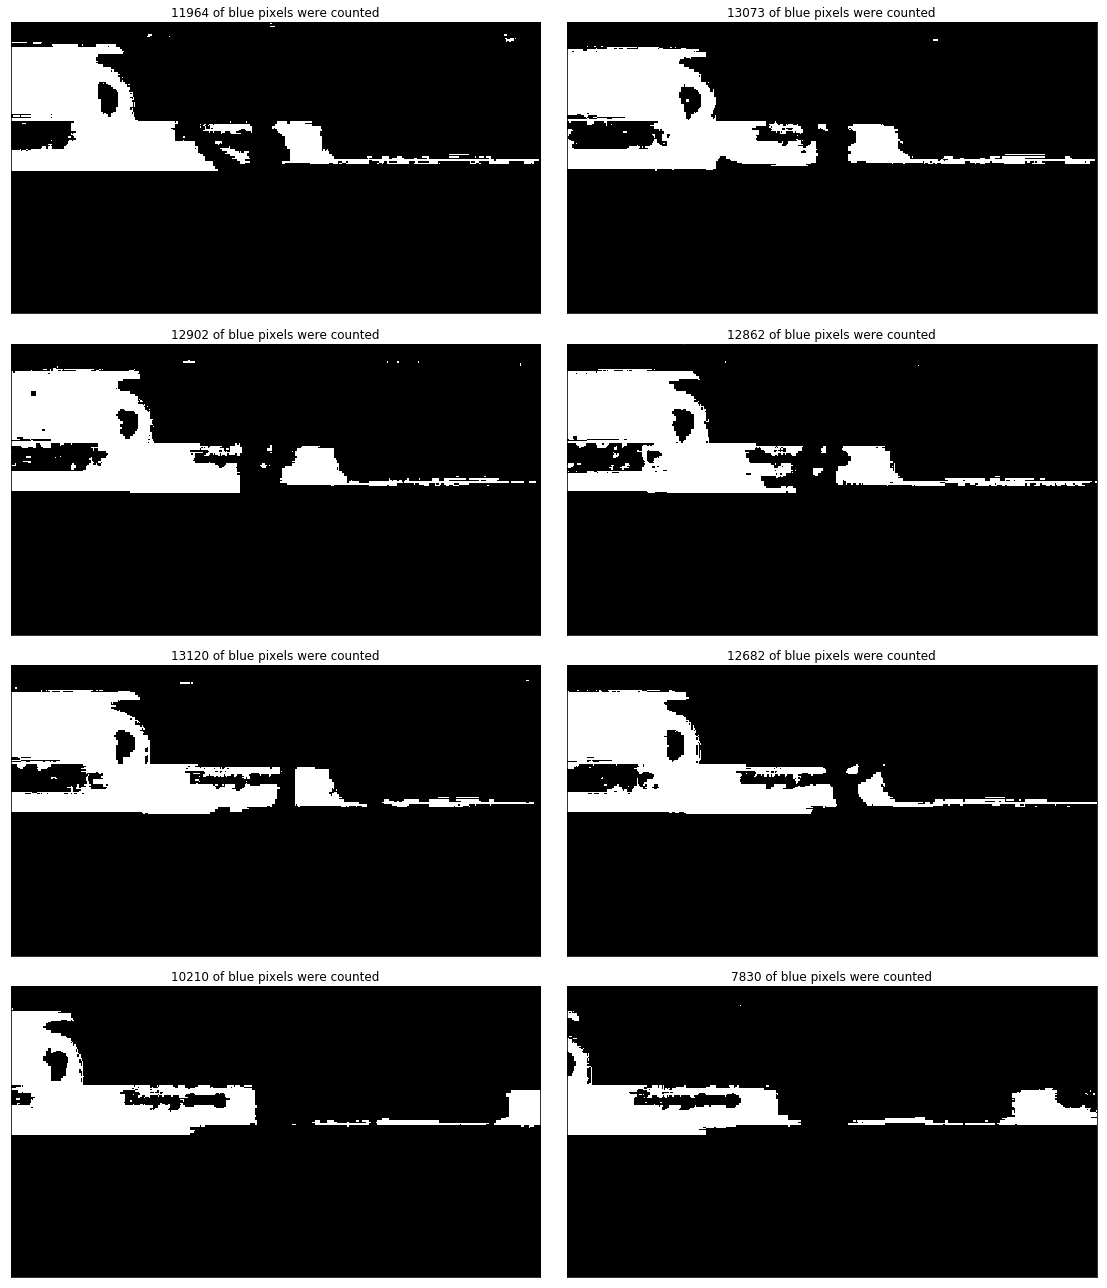

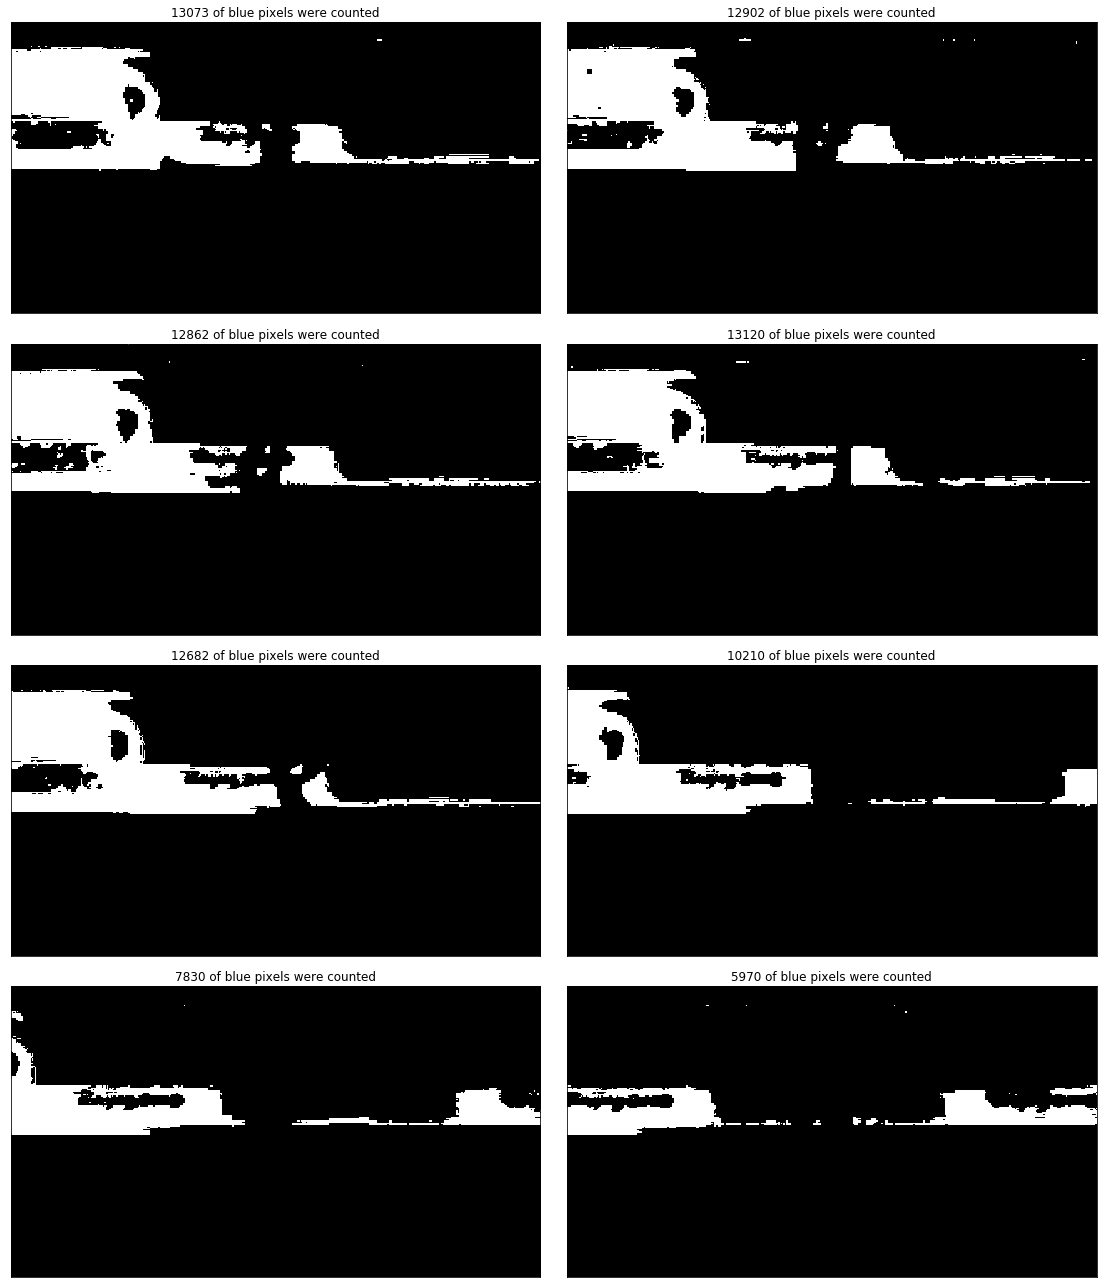

In [6]:
# Here we needed to make multiple plot due to large amount of plots
for n in range(3):
    fig, axes = plt.subplots(4, 2, figsize=(18, 18))
    axes = axes.ravel()
    for k,ax in enumerate(axes):
        ## In the mean time:
        n_pixel, mask, _ = outputs[30*(k+n)]
        # and its mask:
        ax.imshow(mask, cmap='gray')
        ax.set_title(str(n_pixel)+" of blue pixels were counted")
        ax.set_xticks([])
        ax.set_yticks([])
    #
    plt.tight_layout(w_pad=-10)
    plt.show()

## Exercise 2: The return of the HOG.

Do you remember HOG? No? Well, it's okay, since all you need is to remember how to use it, here is a small reminder

Image has dimensions: (480, 640, 3)


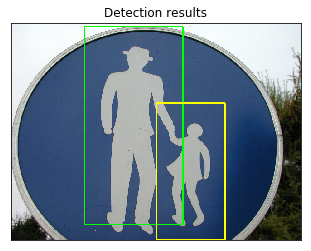

In [7]:
# initialize the HOG descriptor/person detector
hog = cv.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# load base image (check that we are not scaling, normalizing or changing the channels)
img = cv.imread(os.path.join('..','data', 'person_454.bmp'))
print('Image has dimensions: {}'.format(img.shape))

# The HOG detector returns an array with the Regions of maximum likehood to contain a human-shaped-form
rects, weights = hog.detectMultiScale(img , winStride=(4, 4), padding=(8, 8), scale=1.05)

# draw the original bounding boxes
persons = 0;
for k, (x, y, w, h) in enumerate(rects):
    cv2.rectangle(img , (x, y), (x + w - 1, y + h -1), (0, 255, k * 256), 2)
    
display_image(img);
plt.title('Detection results')
plt.xticks([])
plt.yticks([]);

Finally, you will glue together your brand new image processing function and the HOG descriptor from OpenCV above.

### Testing your function:

To test your function you need to process the video: ``../data/videos/video_skater.avi``. At each frame, you will use HOG to detect any person in the frame. At the end of the function you should return: 

* The image __frame__ corresponding to __the seconds 1, 2, ... , 10__ of the video with the rectangle showing the "detected area". 

__Hint __: Check the second assignment if you have no idea what am I talking about.

__Be sure to display all the 10 frames for grading__


In [8]:
def detection_fn(detector, image, params):
    """
    Run pedestrian detector on a given image.
    
    :param detector: HOG Detector instance
    :param image: Image to process
    :param params: Extra parameters needed by the function
    :return: Detected pedestrian bounding boxes
    """

    # The HOG detector returns an array with the Regions of maximum likehood to contain a human-shaped-form
    rects, weights = detector.detectMultiScale(image , winStride=(4, 4), padding=(8, 8), scale=1.05)
    
    # Return rectangle if there is a detection
    if(len(rects)):
        return image, rects[0]
    else:
        return image, (0, 0, 0, 0)
    
# Video file
file_path =  os.path.join('..','data', 'videos', 'video_skater.avi')
outputs = transform_video_file(file_path, lambda im, p: detection_fn(hog, im, p), n_frame=-1)

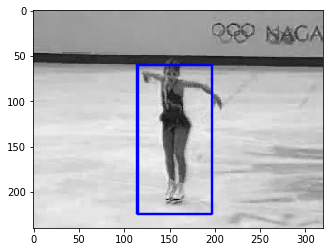

In [9]:
# YOUR CODE HERE
img, (x, y, w, h) = outputs[0]
im = cv2.rectangle(img.copy() , (x, y), (x + w - 1, y + h -1), (255, 0, 0), 2, lineType=cv.LINE_AA)
display_image(im)

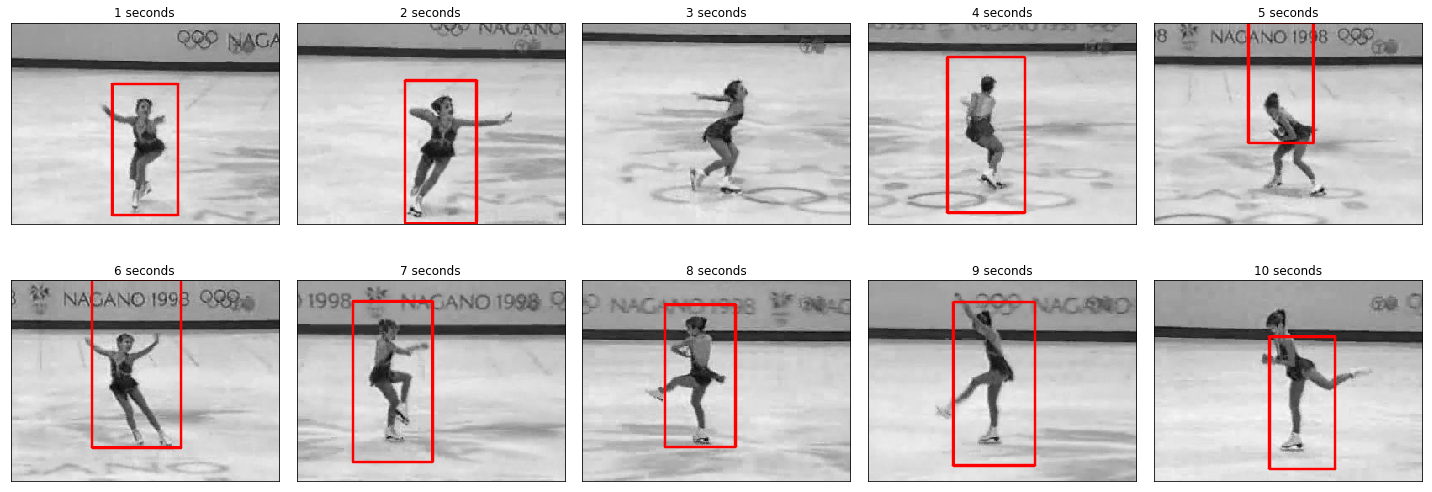

In [10]:
# Retrieve frame rate
video = cv2.VideoCapture(file_path)
fps = int(video.get(cv2.CAP_PROP_FPS))
video.release()

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.ravel()
for k in range(10):
    # Plot
    img, (x, y, w, h) = outputs[fps*(k+1)]
    im = cv2.rectangle(img.copy() , (x, y), (x + w - 1, y + h -1), (255, 0, 0), 2, lineType=cv.LINE_AA)
    ax[k].imshow(im)
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_title(str((k+1)) + " seconds")
    
plt.tight_layout(h_pad=-10)

## 2 Face Tracking

Up to now, the frames of the video were considered as single image having no relationship between them. However, this is not the best approach: the correlation between two consecutive frames is large, since the image will displace or change in the next frame with respect to the previous one only by few pixels. We can rely on this to build a smarter detector. 

The case study for the next sections will be face tracking. The task is to provide a bounding box where the face is located. A number of methods will be analysed and benchmarked against each other. The baseline will be established with a standard face detector based on [Viola, Jones](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf) work (*i.e. no tracking*). Then, you will compare it against the tracking algorithms.

The methods to use and compare are the following:

- Frame-wise face detection (Baseline)
- Tracking: 'MIL', 'KCF', 'TLD', 'MedianFlow', 'Mosse'

For comparison, you will be asked  to implemented the following metrics:

- Euclidean distance between center's bounding box
- Intersection over Union
- Computation time

Your first task is to implement the preprocessing function that will be applied on every frame before actually doing the tracking. You can apply any transformation you want to each frames.

In [11]:
# Load all images
def preprocessing_fn(image, params):
    """
    Apply preprocessing on a given image.
    
    :param image: Image to preprocess
    :param params: Extra parameters
    :return: Preprocessed image
    """
    
    # Normalization of brightness for every frames
    img = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX)
    return img

file_path =  os.path.join('..','data', 'videos', 'speaker.avi')
images = transform_video_file(file_path, preprocessing_fn, n_frame=350)
print('Video contains a total of {} frames'.format(len(images)))

Video contains a total of 350 frames


### 2.2 Face Detection

The detection baseline is established using an instance of `cv::CascadeClassifier` which implements the approach proposed by Viola & Jones for object detection. 

Your task is to complete the implementation of the `detection_fn` which, given an instance of a classifier and an image, return the bounding box where the face is located. More information about the detector can be found in the [doc](https://docs.opencv.org/3.4.4/d1/de5/classcv_1_1CascadeClassifier.html#ab3e572643114c43b21074df48c565a27).

Be sure to implement a solution to deal with the situation where multiple boxes are returned by the classifier. The function must return **ONLY** one bounding box.

In [12]:
def detection_fn(detector, image):
    """
    Run face detection on a given `image` with an instance of CascadeClassifier
    
    :param detector: CascadeClassifier instance
    :param image: Frame on which to run detection
    :return: bounding box if any or None
    """
    
    # Face detection algorithm with CascadeClassifier
    # Scaling by 1.1 to increase speed without affecting too much the accuracy
    # minNeighbors is higher there is less detection but it is higher in quality
    rects = detector.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5);
    
    if(len(rects)):
        return rects[0]
    
    else:
        return None

The code in the following cell will test your `detection_fn` and display the outcome for the first four frames of the video.

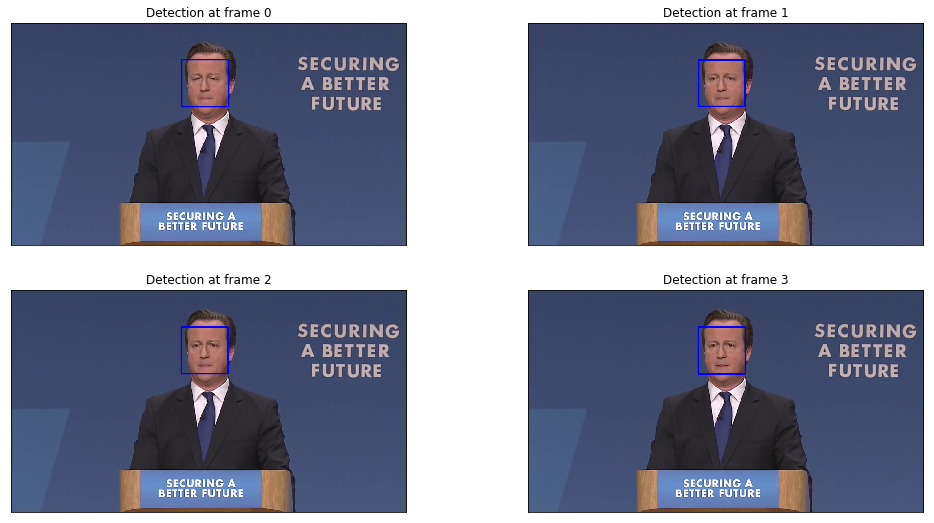

In [13]:
# Load face detector
fpath = os.path.join('..', 'data', 'haarcascade_frontalface_alt2.xml')
fdet = cv.CascadeClassifier(fpath)
assert fdet.empty() is not True

# Detect 
detection_out= []
for img in images[:4]:
    bbox = detection_fn(fdet, img)
    detection_out.append(bbox)
    
# Display
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
for k, box in enumerate(detection_out):
    # Draw rectangle
    x, y, w, h = box
    im = cv.rectangle(images[k].copy(), (x, y), (x + w -1, y + h -1), (255, 0, 0), 3, lineType=cv.LINE_AA)
    # Display
    r = k // 2
    c = k % 2
    display_image(im, axes=ax[r][c])
    ax[r][c].set_title('Detection at frame {}'.format(k))
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([]);    

### 2.3 Face Tracking

Similar to what you have done before, you will have to complete the `tracking_fn` that will perform the tracking step. Given one instance of `cv::Tracker` [(doc)](https://docs.opencv.org/3.4.4/d0/d0a/classcv_1_1Tracker.html) and a  input image, the function will return the bounding box where the object (*i.e. face*) is located.

Again, be sure to **ONLY** one bounding box.

In [14]:
def tracking_fn(tracker, image):
    """
    Perform tracking on a given image.
    
    :param tracker: Tracker instance
    :param image: Image on which to run tracker
    :return: Bounding box if any
    """

    [detected_face, bounding_box] = tracker.update(image)
    
    return bounding_box

The following cell will test your `tracking_fn` in the same way as what we did earlier b traking the first four frames of the video and displaying the results. 

Corr:  551 121 703 273
Corr:  550 120 702 272
Corr:  549 121 701 273
Corr:  550 122 702 274


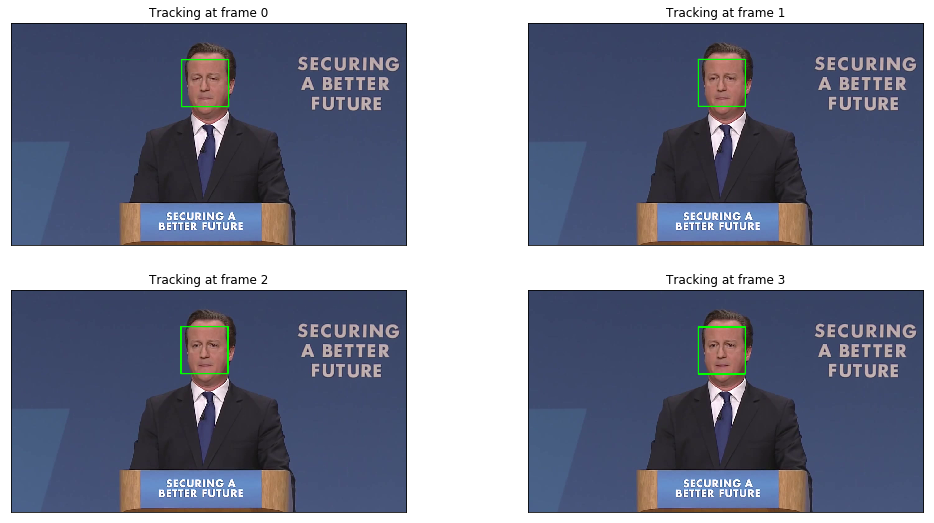

In [15]:
# Create tracker
tracker = create_face_tracker(name='KCF')
tracker.init(images[0], (551, 121, 153, 153))

# Detect 
tracking_out=[]
for img in images[:4]:
    bbox = tracking_fn(tracker, img)
    tracking_out.append(bbox)
           
# Display
fig, ax = plt.subplots(2, 2, figsize=(17, 9))
for k, box in enumerate(tracking_out):
    # Draw rectangle
    x, y, w, h = box
    x = int(x); y=int(y); w=int(w); h=int(h)
    print("Corr: ", x, y, x + w - 1, y + h - 1)
    im = cv.rectangle(images[k].copy(), (x, y), (x + w -1, y + h -1), (0, 255, 0), 3, lineType=cv.LINE_AA)
    # Display
    r = k // 2
    c = k % 2
    display_image(im, axes=ax[r][c])
    ax[r][c].set_title('Tracking at frame {}'.format(k))
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([]);    

### 2.4 Comparison

#### 2.4.1 Metric

The performance of a given tracker will be assessed with the following metrics:

- Intersection over Union
- Distance between center's bounding boxes
- Execution time

##### 2.4.1.1 Intersection over Union

Your task is to complete the implementation of the `iou_metric` function. The function will return the *Intersection over Union* given two bounding boxes, namely `box_a` and `box_b`.

You can find the metric as the Jaccard index https://en.wikipedia.org/wiki/Jaccard_index. Feel free to modify the implementation below to adapt it to your function output.

In [16]:
def iou_metric(box_a, box_b):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes (x, y, w, h)
    
    :param box_a: First bounding box
    :param box_b: Second bounding box
    :return: Intersction over Union
    """
    iou = 0.0
    
    xa, ya, wa, ha = box_a
    xfin_a = xa + wa
    yfin_a = ya + ha
    
    xb, yb, wb, hb = box_b
    xfin_b = xb + wb
    yfin_b = yb + hb
    
    boxA_area = (xfin_a - xa + 1) * (yfin_a - ya + 1)
    boxB_area = (xfin_b - xb + 1) * (yfin_b - yb + 1)
    
    # Calculating the boundaries of the intersection rectangle
    
    xA = max(xa, xb)
    yA = max(ya, yb)
    xB = min(xfin_a, xfin_b)
    yB = min(yfin_a, yfin_b)
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    iou = interArea / float(boxA_area + boxB_area - interArea)
    
    # return the intersection over union value
    return iou

In [17]:
# Usage + sanity check
IoU = iou_metric(box_a=[39, 63, 164, 49], box_b=[40, 63, 165, 49])
print('Intersection over Union: {:.3f}'.format(IoU))
assert round(IoU, 3) == 0.982, 'Something went wrong at your implementation of the `iou_metric` function'

Intersection over Union: 0.982


##### 2.4.1.2 Center's distance

Complete the `center_metric` function that compute the euclidean distance between two bounding box centers, define as:

$$
d_i = \left|\left| c_i^A - c_i^B \right|\right|
$$

where `A` and `B` are the two bounding boxes (*i.e. detection + ground truth*)


In [18]:
def center_metric(box_a, box_b):
    """
    Compute the Euclidean distance between two given bounding boxes
    
    :param box_a: First bounding box
    :param box_b: Second bounding box
    :return: Distance
    """
    d = 0.0
    
    xa, ya, wa, ha = box_a
    centerA_x = xa + wa / 2
    centerA_y = ya + ha / 2
    
    xb, yb, wb, hb = box_b
    centerB_x = xb + wb / 2
    centerB_y = yb + hb / 2
    
    dx = centerB_x - centerA_x
    dy = centerB_y - centerA_y
    
    d = np.sqrt((np.power(dx, 2) + np.power(dy, 2)))

    return d
    

In [19]:
# Usage + sanity check
dist = center_metric(box_a=[39, 63, 164, 49], box_b=[40, 63, 165, 49])
print('Distance: {:.3f}'.format(dist))
assert round(dist, 3) == 1.500, 'Somehting went wrong at your implementation of the `center_metric` function'

Distance: 1.500


##### 2.4.1.3 Execution time

The function `time_metric` will measure the execution time of a given function defined in `processing_fn`. Its signature must be `processing_fn() -> Any`.
If the `processing_fn` return some values, they will be passed through the `time_metric` function. Therefore the return value is a tuple containing the execution time in first position and anything returned by `processing_fn` in the second position.

In [20]:
def time_metric(processing_fn):
    """
    Measure the execution time of a given function (i.e. lambda function)
    
    :param processing_fn:  Lambda function to be timed
    :return: Execution time in milli-seconds
    """
    s0 = cv.getTickCount()
    retval = processing_fn()
    s1 = cv.getTickCount()
    return (1000.0 * (s1 - s0)) / cv.getTickFrequency(), retval

The `time_metric` function can be used as follow:


In [21]:
# Using user define function with proper prototype
def wasting_time_func():
    _time.sleep(0.75)
    return 'Done'
    
# Call metric
dt, ret = time_metric(wasting_time_func)
print('User-defined function took: {:.3f} ms, with return value {}'.format(dt, ret))

User-defined function took: 750.878 ms, with return value Done


In [22]:
# Using user define function with proper prototype
def wasting_time_func():
    _time.sleep(0.75)
    return 'Done'
    
# Call metric
dt, ret = time_metric(wasting_time_func)
print('User-defined function took: {:.3f} ms, with return value {}'.format(dt, ret))

User-defined function took: 750.888 ms, with return value Done


In [23]:
# Using lambda function 
dt, ret = time_metric(lambda: _time.sleep(0.5))
print('Lambda function took: {:.3f} ms'.format(dt))

Lambda function took: 500.725 ms


#### 2.4.2 Load Ground Truth

The true bounding boxes are stored into the `data/videos/speaker_gt.txt` text file. Each line contains the true bounding box for the corresponding frame.

Your task is to complete the `load_ground_truth` that parses the file and return a list of boxes.

In [24]:
def load_ground_truth(filename):
    """
    Load all detection stored into a given file
    
    :param filename: Path to the text file storing the ground truth
    :return: List of bounding boxes
    """
    bboxes = []
    
    
    print("File: ", filename)
    
    with open(filename) as f:
        for line in f:
            line = line.replace("[", "")
            line = line.replace("]", "")
            
            bbox_temp = [float(num) for num in line.split(';')]
            bboxes.append(bbox_temp)
    
    
    return bboxes

Load every face bounding boxes into a list

In [25]:
# Load ground truth
fname = os.path.join('..', 'data', 'videos', 'speaker_gt.txt')
gt_bbox = load_ground_truth(filename=fname)
print('There is a total of {} bounding boxes'.format(len(gt_bbox)))

File:  ../data/videos/speaker_gt.txt
There is a total of 1871 bounding boxes



#### 2.4.3 Experimental setup

In the `run_experiment` function, given a list of pair `{Image, Ground truth}`, it will perform the tracking/detection on all images and run the various *metrics* that have been implemented earlier. 

The results for a **single** frame will be stored into a dictionary with the following entries:

- `bbox` will contain the detected region
- `metrics` will contain all the metrics computed during the experiment. The metrics are stored in a `tuple` ordered as : `IoU, Distance, Time`


The next cells run the experiment with the `detection_fn` in order to establish the baseline. Later, on the tracking results, all the metrics will be compared against it.

In [26]:
def run_experiment(images, true_bbox, tracking_fn):
    """
    Run a given detection/tracking function on a list of images.
    
    :param images: List of consecutive images to processed (already preprocessed)
    :param bboxes: List of true bounding boxes (Ground truth)
    :param tracking_fn: Function running detection/tracking for ONE frame
    :return: List of dictionnaries for each frames holding detected bounding box if any and the various metrics
    """
    metrics = []

    for img, gt_bbox in zip(images, true_bbox):
        
        # Run metrics + tracking
        dt, bbox = time_metric(lambda: tracking_fn(img))  
        iou = iou_metric(bbox, gt_bbox)
        dist = center_metric(bbox, gt_bbox)
        # Accumulate results
        metrics.append({'bbox': bbox, 'metric': (iou, dist, dt)})
    # Done
    return metrics

# Run detection, no tracking
detection_exp = run_experiment(images=images, true_bbox=gt_bbox, tracking_fn=lambda x: detection_fn(fdet, x))

Your task is to run the same experiment (*i.e. `run_experiment`*) for all the selected trackers. To instantiate the tracker using its name, you have to use the function `create_face_tracker(str) -> cv::Tracker`.

For the initialisation of the tracker, you can use the region: `(551, 121, 175, 175)`.

In [27]:
# List of tracker to use
trackers_name = ['MIL', 'KCF', 'TLD', 'MedianFlow', 'Mosse']
# Run experiments for each tracker
trackers_exp = {}
for name in trackers_name:
    
    tracker = create_face_tracker(name=name)
    tracker.init(images[0], (551, 121, 175, 175))
    
    trackers_exp[name] = run_experiment(images=images, true_bbox=gt_bbox, tracking_fn=lambda x: tracking_fn(tracker, x))
    


#### 2.4.4 Results

In this section we ask you to display and discuss about the outcome of the tracking experiments. Compare every tracker with the baseline established earlier and discuss what you observed.

Report the following quantities:

- The `min`, `max`, `mean`, `std` of each metrics for every tracker and the baseline, comment on the values
- Display the detection/tracking of the `best` and the `worst` IoU for each algorithm
- Discuss the performance of each tracker
- Discuss the pros and cons of each metrics
- Investigate each tracker and explain briefly what is the methods used under the hood.


In [28]:
metric_extrema = {}
metric_statistical = {}
max_iou_perf = {}
min_iou_perf = {}

nb_images = len(trackers_exp['MIL'])
for name in trackers_name:
    max_iou, min_iou, max_dt, min_dt, max_dist, min_dist = 0, np.inf, 0, np.inf, 0, np.inf
    iou_array, dist_array, dt_array = [], [], []
    for img_index in range(0, nb_images):
        
        iou_img =  trackers_exp[name][img_index]['metric'][0]
        iou_array.append(iou_img)
        if iou_img < min_iou:
            min_iou = iou_img
            min_iou_perf[name] = trackers_exp[name][img_index]['bbox']
        elif iou_img > max_iou:
            max_iou = iou_img
            max_iou_perf[name] = trackers_exp[name][img_index]['bbox']
            
        dist_img = trackers_exp[name][img_index]['metric'][1]
        dist_array.append(dist_img)
        if dist_img < min_dist:
            min_dist = dist_img
        elif dist_img > max_dist:
            max_dist = dist_img
            
        dt_img = trackers_exp[name][img_index]['metric'][2]
        dt_array.append(dt_img)
        if dt_img < min_dt:
            min_dt = dt_img
        elif dt_img > max_dt:
            max_dt = dt_img
    
    # Computing the remaining statistical values, i.e mean and std for each metric
    mean_iou, mean_dist, mean_dt = np.sum(iou_array) / nb_images, np.sum(dist_array) / nb_images, np.sum(dt_array) / nb_images
    std_iou, std_dist, std_dt = np.std(iou_array), np.std(dist_array), np.std(dt_array)
    metric_extrema[name] = [max_iou, min_iou, max_dt, min_dt, max_dist, min_dist]
    metric_statistical[name] = [mean_iou, std_iou, mean_dist, std_dist, mean_dt, std_dt]
    
# Analysis of the baseline performances

max_iou, min_iou, max_dt, min_dt, max_dist, min_dist = 0, np.inf, 0, np.inf, 0, np.inf
iou_array, dist_array, dt_array = [], [], []
name = 'Baseline'
for img_index in range(0, nb_images):
    
    iou_img =  detection_exp[img_index]['metric'][0]
    iou_array.append(iou_img)
    if iou_img < min_iou:
        min_iou = iou_img
        min_iou_perf[name] = tuple(detection_exp[img_index]['bbox'])
    elif iou_img > max_iou:
        max_iou = iou_img
        max_iou_perf[name] = detection_exp[img_index]['bbox']

    dist_img = detection_exp[img_index]['metric'][1]
    dist_array.append(dist_img)
    if dist_img < min_dist:
        min_dist = dist_img
    elif dist_img > max_dist:
        max_dist = dist_img

    dt_img = detection_exp[img_index]['metric'][2]
    dt_array.append(dt_img)
    if dt_img < min_dt:
        min_dt = dt_img
    elif dt_img > max_dt:
        max_dt = dt_img
        
mean_iou, mean_dist, mean_dt = np.sum(iou_array) / nb_images, np.sum(dist_array) / nb_images, np.sum(dt_array) / nb_images
std_iou, std_dist, std_dt = np.std(iou_array), np.std(dist_array), np.std(dt_array)

metric_extrema[name] = [max_iou, min_iou, max_dt, min_dt, max_dist, min_dist]
metric_statistical[name] = [mean_iou, std_iou, mean_dist, std_dist, mean_dt, std_dt]

In [29]:
comparison_name = ['MIL', 'KCF', 'TLD', 'MedianFlow', 'Mosse', 'Baseline']

for name in comparison_name:
    print("---- ", name, " ----")
    print("Intersection over union : the mean value is ", metric_statistical[name][0], " and the std ", metric_statistical[name][1])
    print("Center's distance : the mean value is ", metric_statistical[name][2], " and the std ", metric_statistical[name][3])
    print("Execution time : the mean value is ", metric_statistical[name][4], "[ms] and the std ", metric_statistical[name][5], "[ms]")

----  MIL  ----
Intersection over union : the mean value is  0.8597090455016564  and the std  0.06826464506421469
Center's distance : the mean value is  9.04391533757696  and the std  4.853719052365043
Execution time : the mean value is  42.96265274857143 [ms] and the std  3.6758722705188127 [ms]
----  KCF  ----
Intersection over union : the mean value is  0.8730545960177267  and the std  0.06694870815623216
Center's distance : the mean value is  7.7656473535112065  and the std  4.5444695782453355
Execution time : the mean value is  25.085640734285718 [ms] and the std  2.613934631921256 [ms]
----  TLD  ----
Intersection over union : the mean value is  0.44860141424206396  and the std  0.08733909378287265
Center's distance : the mean value is  57.80506804627019  and the std  10.957176663173088
Execution time : the mean value is  72.98414362 [ms] and the std  9.124636124678183 [ms]
----  MedianFlow  ----
Intersection over union : the mean value is  0.8237540504329617  and the std  0.0729

**We can see that the trackers, with the exception of the TLD, offer far more satisfactory results than the cascade classifier, firstly because their values fluctuate less (i.e the std is low), and they also offer better results for both the iou and the center's distance. Concerning the execution time, we can draw the same conclusion: the fastest one is the Mosse tracker which, on average, runs 70 times faster than the TLD, and more than 300 times faster than the cascade classifier, while getting much better results for the other metrics. The best one in terms of quality of results seems to be the KCF, with the trade-off of a slightly longer execution time (about 15 times slower than the Mosse tracker)**

In [30]:
import seaborn as sns
import pandas as pd
sns.set(style="ticks")

iouDf = pd.DataFrame()
dtDf = pd.DataFrame()
distDf = pd.DataFrame()

for name in comparison_name:
    max_iou = metric_extrema[name][0]
    min_iou = metric_extrema[name][1]
    max_dt = metric_extrema[name][2]
    min_dt = metric_extrema[name][3]
    max_dist = metric_extrema[name][4]
    min_dist = metric_extrema[name][5]
    
    iouDf[name] = [min_iou, max_iou]
    dtDf[name] = [min_dt, max_dt]
    distDf[name] = [min_dist, max_dist]

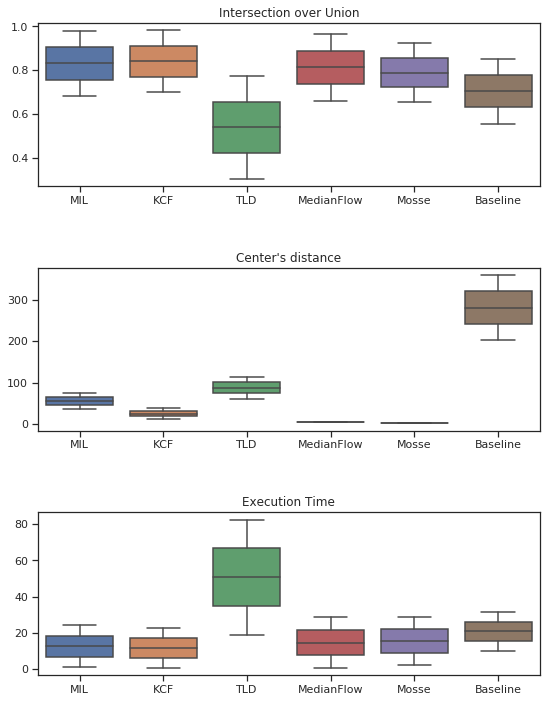

In [31]:
f = plt.figure(figsize=(9,12))
plt.subplots_adjust(hspace = .5)
ax = f.add_subplot(311)
ax.set_title("Intersection over Union")
ax2 = f.add_subplot(312)
ax2.set_title("Center's distance")
ax3 = f.add_subplot(313)
ax3.set_title("Execution Time")

sns.boxplot(data=iouDf, ax=ax)
sns.boxplot(data=dtDf, ax=ax2)
sns.boxplot(data=distDf, ax=ax3)

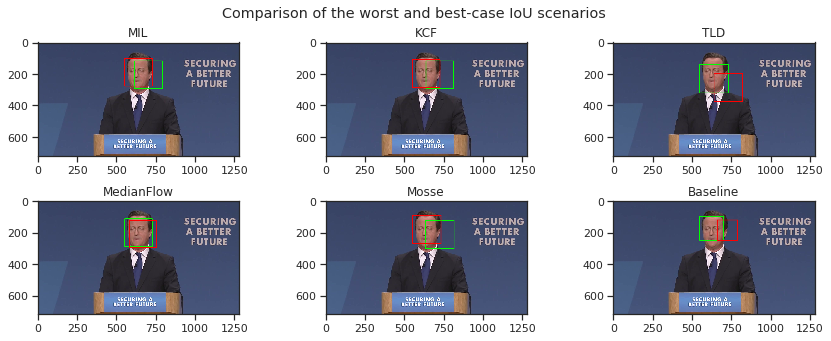

In [32]:
# Display of the tracking performance for the worst and best-case secnarios in term of IoU
index = {'MIL': 1, 'KCF': 2, 'TLD': 3, 
         'MedianFlow': 4, 'Mosse': 5, 'Baseline': 6}

fig = plt.figure(figsize=(14,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Comparison of the worst and best-case IoU scenarios')

for name in comparison_name:
    rectangle_max = max_iou_perf[name]
    rectangle_min = min_iou_perf[name]
    #print("rect: ", rectangle_coord, name)
    pt1_max = (int(rectangle_max[0]), int(rectangle_max[1]))
    pt2_max = (int(rectangle_max[0] + rectangle_max[2]), int(rectangle_max[1] + rectangle_max[3]))
    
    pt1_min = (int(rectangle_min[0]), int(rectangle_min[1]))
    pt2_min = (int(rectangle_min[0] + rectangle_min[2]), int(rectangle_min[1] + rectangle_min[3]))
    
    im = cv.rectangle(images[0].copy(), pt1_max, pt2_max, (0, 255, 0), 3, lineType=cv.LINE_AA)
    im = cv.rectangle(im.copy(), pt1_min, pt2_min, (0, 0, 255), 3, lineType=cv.LINE_AA)
    
    plt.subplot(2, 3, index[name])
    display_image(im)
    plt.title(name)

**As we can see from the figure above, some trackers offer much reliable results when considering the variability between the extreme scenarios than others. This is for instance the case of the MedianFlow and the MIL (which displayed a very low standard deviation in the discussion above). On the other side, the cascade classifier and the TLD are much less precise when we are facing a worst-case tracking / detection**

**Short explanation for each tracker:
- MIL: The current location of the object we want to track, along with some regions of its neighborhood, are considered as positive "bags", ensuring that one of the patches is nicely centered on the object
- KCF: Same principle than for MIL, except that we are also considering patches overlapping on multiple regions of the MIL, which brings more accuracy to the tracking
- TLD: The tracker first tries to track the object of interest (Tracking), then estimates the detection error (Learn) to update its parameteres (Detect). Can lead to multiple jumps during the tracking, thus a lot of false positives 
- MedianFlow: Uses the time dimension to track an object, by measuring the discrepancies between the backward and the forward directions. Can fail when the motions are too sudden between two consecutive frames.  
- Mosse: Uses adaptive correlation to produce correlation filters **